In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

from datetime import datetime, timedelta
from itertools import product

import utils

In [2]:
# read csv
bandwidth = pd.read_csv('data/bandwidth.csv')
bandwidth.columns = ['bandwidth']
# input hourly dates starting from 2019/01/01
inital_date = datetime(2000, 1, 1, 0, 0, 0)
hourly_delta = timedelta(hours=1)

hourly_dates = []
for i in range(bandwidth.shape[0]):
    hourly_dates.append((i * hourly_delta) + inital_date)
    
bandwidth['date'] = pd.to_datetime(hourly_dates)
bandwidth.set_index('date', inplace=True)
bandwidth.index.freq = 'H'
bandwidth.head()


,bandwidth
date,
2000-01-01 00:00:00,1000.496714
2000-01-01 01:00:00,1000.969408
2000-01-01 02:00:00,1002.046019
2000-01-01 03:00:00,1004.702118
2000-01-01 04:00:00,1007.447816


In [3]:
bandwidth.shape

(10000, 1)

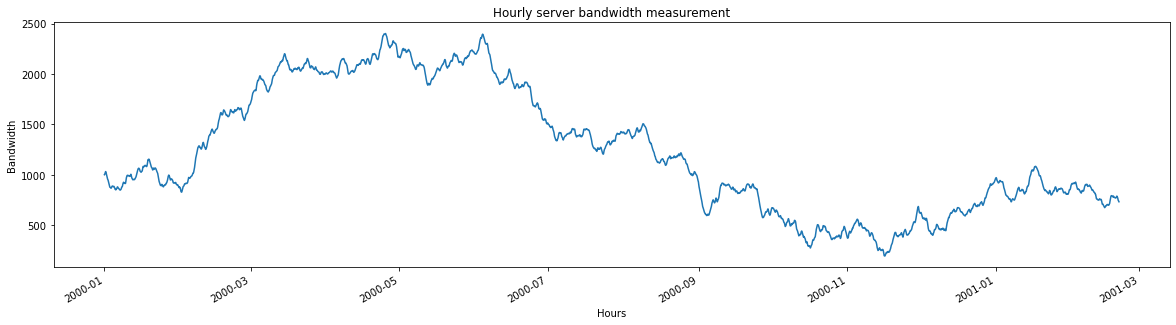

In [4]:
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(bandwidth['bandwidth'])
ax.set_ylabel('Bandwidth')
ax.set_xlabel('Hours')

plt.title('Hourly server bandwidth measurement')

fig.autofmt_xdate()
plt.show()

### Test stationarity

In [5]:
adf_test = adfuller(bandwidth.bandwidth)
print('Stationary' if adf_test[1] < 0.05 else 'Non stationary')

Non stationary


In [6]:
bandwidth['diff_bandwidth'] = bandwidth['bandwidth'].diff()

In [7]:
adf_test1 = adfuller(bandwidth.diff_bandwidth[1:])
print('Stationary' if adf_test1[1] < 0.05 else 'Non stationary')

Stationary


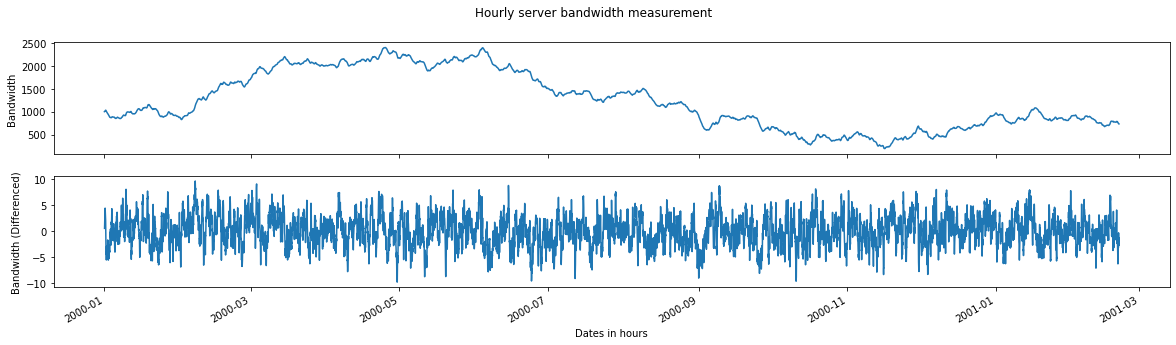

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20,5))
fig.suptitle('Hourly server bandwidth measurement')

ax1.plot(bandwidth['bandwidth'])
ax1.set_ylabel('Bandwidth')
ax1.set_xlabel('Hours')

ax2.plot(bandwidth['diff_bandwidth'])
ax2.set_ylabel('Bandwidth (Differenced)')
ax2.set_xlabel('Dates in hours')

fig.autofmt_xdate()
plt.show()

### Create test and training sets

In [9]:
test_set_size = 168 # one week worth for forecasting

df = bandwidth[1:].copy()

train = df[:-test_set_size]
test = df[-test_set_size:]

print(len(train))
print(len(test))

9831
168


### Create the optimize_arima function that returns the arima order and the aic sorted in descending order

In [10]:
def optimize_arima(ser : pd.Series, p_max : int = 4, q_max : int = 4, i : int = 1):
    ps = range(0, p_max)
    qs = range(0, q_max)
    eyes = range(0, i)
    combinations = product(ps, eyes, qs)
    
    arr = []
    for order in combinations:
        try:
            model = ARIMA(ser, order=order).fit()        
            arr.append((order, model.aic))
        except:
            continue
    
    res = pd.DataFrame(arr, columns=['order', 'aic'])
    res.sort_values(by=['aic'], inplace=True)
    
    return res

In [11]:
optimize_arima(df.diff_bandwidth)

/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,order,aic
14,"(3, 0, 2)",28453.189466
11,"(2, 0, 3)",28453.366131
10,"(2, 0, 2)",28453.664598
15,"(3, 0, 3)",28455.396110
7,"(1, 0, 3)",28464.634168
6,"(1, 0, 2)",28513.629053
13,"(3, 0, 1)",28536.471209
12,"(3, 0, 0)",28559.643627
9,"(2, 0, 1)",28561.635401
8,"(2, 0, 0)",28563.429411


### We pick the best performing order and use the order

In [83]:
arima_order = (3, 0, 2)
arima_model = ARIMA(df.diff_bandwidth, order=arima_order).fit()
res = arima_model.resid
print(arima_model.aic, arima_model.sse)

28453.18946581494 10060.46443673856


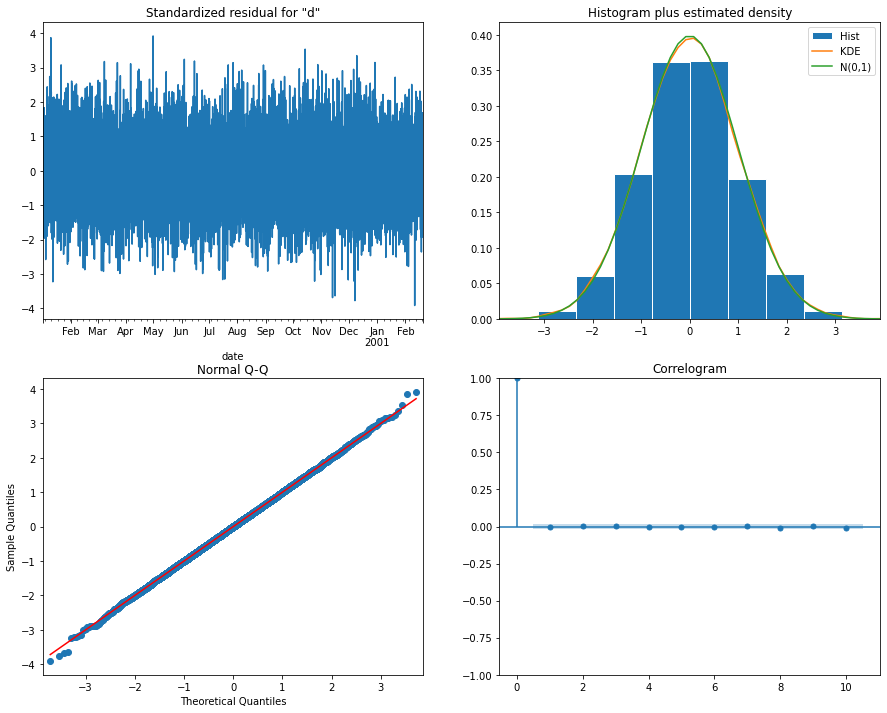

In [13]:
arima_model.plot_diagnostics(figsize=(15, 12));

In [14]:
# using the ljuncbox function to stest that residuals are IID
ljungbox_result = acorr_ljungbox(res, np.arange(1, 20, 1))
print(ljungbox_result)

      lb_stat  lb_pvalue
1    0.000682   0.979164
2    0.010280   0.994873
3    0.016169   0.999456
4    0.155840   0.997117
5    0.525091   0.991176
6    0.538755   0.997334
7    0.882290   0.996511
8    1.333923   0.995134
9    1.335405   0.998194
10   1.890871   0.997110
11   2.713002   0.994001
12   2.812485   0.996729
13   4.347027   0.986909
14   7.207185   0.926429
15   7.591398   0.939118
16   7.725507   0.956621
17   7.921370   0.968199
18   9.509124   0.946757
19  15.066654   0.718352


### 6.6 Forecasting bandwidth usage

In [60]:
def arima_predict_function(arr, arma_order, window):
    arima = ARIMA(arr, order=arma_order)
    fit = arima.fit()
    return fit.get_forecast(steps=window).predicted_mean

total_len = df.shape[0]
train_len = train.shape[0]
window = 2

predict_mean = utils.pd_rolling_forecast(df.diff_bandwidth, total_len, train_len, window, 'mean')
predict_last = utils.pd_rolling_forecast(df.diff_bandwidth, total_len, train_len, window, 'last')
predict_arma = utils.pd_rolling_forecast(df.diff_bandwidth, total_len, train_len, window, 'ARMA', arima_order, arima_predict_function)


In [35]:
test.loc[:, 'predict_mean'] = predict_mean
test.loc[:, 'predict_last'] = predict_last
test.loc[:, 'predict_arma'] = predict_arma

test.head()

/var/folders/xl/w9y4tjx938vdwtkgzwxsxx8m0000gp/T/ipykernel_19827/669379554.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'predict_mean'] = predict_mean
/var/folders/xl/w9y4tjx938vdwtkgzwxsxx8m0000gp/T/ipykernel_19827/669379554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'predict_last'] = predict_last
/var/folders/xl/w9y4tjx938vdwtkgzwxsxx8m0000gp/T/ipykernel_19827/669379554.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

,bandwidth,diff_bandwidth,predict_arma,predict_mean,predict_last
date,,,,,
2001-02-13 16:00:00,717.176939,-5.943995,-5.456125,-0.028214,-5.791207
2001-02-13 17:00:00,711.311745,-5.865194,-4.888193,-0.028214,-5.791207
2001-02-13 18:00:00,708.114679,-3.197066,-5.350360,-0.029410,-5.865194
2001-02-13 19:00:00,707.024482,-1.090197,-4.779918,-0.029410,-5.865194
2001-02-13 20:00:00,707.689774,0.665291,-0.410349,-0.029840,-1.090197


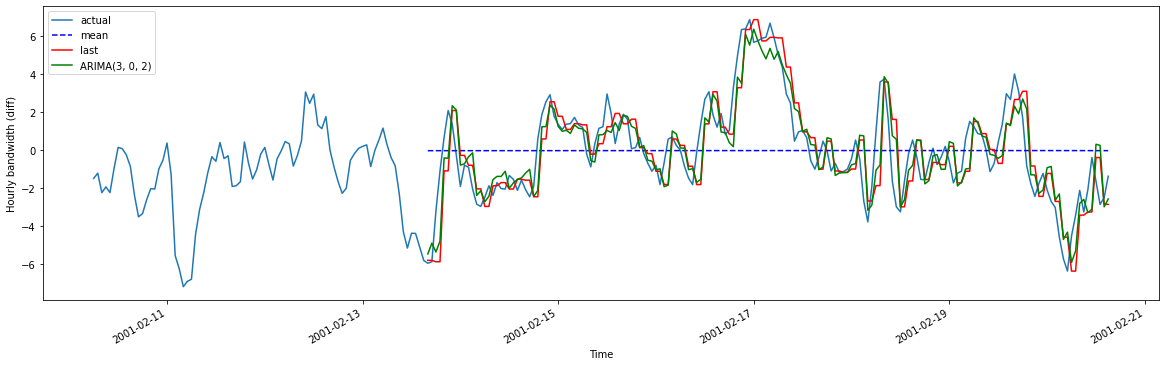

In [50]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(df.diff_bandwidth[-250:], label='actual')
ax.plot(test.predict_mean, 'b--', label='mean')
ax.plot(test.predict_last, 'r', label='last')
ax.plot(test.predict_arma, 'g', label=f'ARIMA{arima_order}')
ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth (diff)')

fig.autofmt_xdate()
plt.show()

In [67]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test.diff_bandwidth, predict_mean)
mse_last = mean_squared_error(test.diff_bandwidth, predict_last)
mse_arima = mean_squared_error(test.diff_bandwidth, predict_arma)

print(mse_mean, mse_last, mse_arima)

6.306526957989325 2.2297582947733656 1.773595545522082


In [76]:
k = total_len - test.shape[0] + 1
bandwidth['predict_bandwidth'] = bandwidth['bandwidth'].iloc[k] + test['predict_arma'].cumsum()

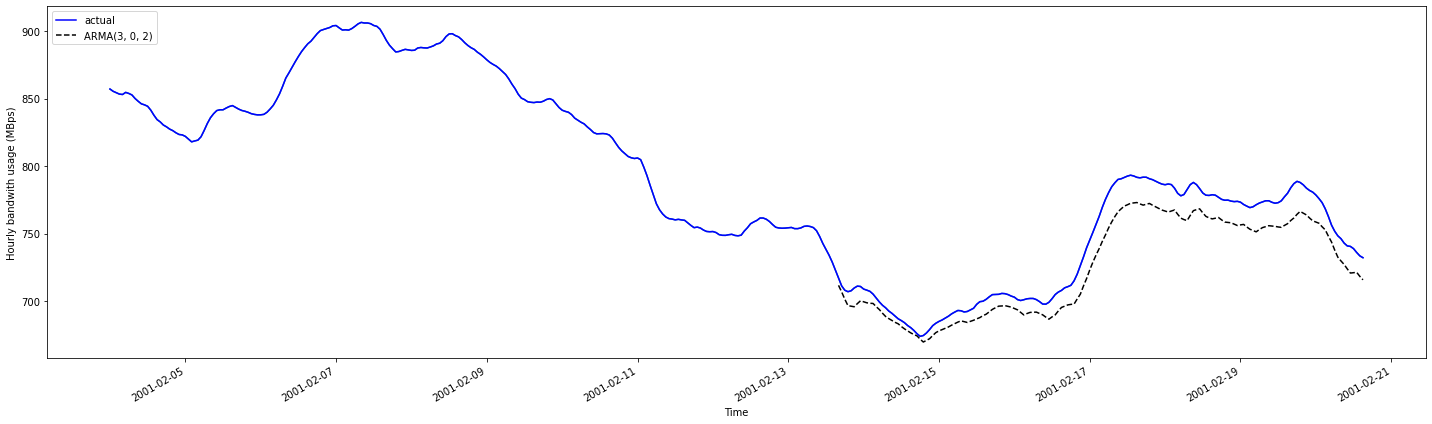

In [77]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(bandwidth['bandwidth'][-400:])
ax.plot(bandwidth['bandwidth'][-400:], 'b-', label='actual')
ax.plot(bandwidth['predict_bandwidth'][-400:], 'k--', label=f'ARMA{arima_order}')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

fig.autofmt_xdate()
plt.tight_layout()

In [79]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(bandwidth.bandwidth[k:], bandwidth.predict_bandwidth[k:])

print(mae)

14.364025133962397
